In [1]:
import os

# os.environ["HF_HOME"]           = r"D:\huggingface_cache"
# os.environ["TRANSFORMERS_CACHE"] = r"D:\huggingface_cache\transformers"
# os.environ["HF_DATASETS_CACHE"]  = r"D:\huggingface_cache\datasets"

In [2]:
import os, math, torch, numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from diffusers import (
    UNet2DConditionModel,
    ControlNetModel,
    AutoencoderKL,
    DDPMScheduler,
)
from transformers import CLIPTokenizer, CLIPTextModel
from bitsandbytes.optim import AdamW8bit

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using device:", device)


/home/anyaji/anaconda3/envs/cv1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device: cuda


In [6]:
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from diffusers.utils import load_image

class SketchEditDataset(Dataset):
    def __init__(self, data, tokenizer, image_size=384, transform=None):
        # with open(json_file, 'r', encoding='utf-8') as f:
        #     self.data = json.load(f)
        self.data = data
            
        self.tokenizer = tokenizer
        self.image_size = image_size
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]

        orig = load_image(item["original_image"]).convert("RGB").resize((self.image_size, self.image_size))
        sketch = Image.new('RGB', (self.image_size, self.image_size), 'white')
        target = load_image(item["edited_image"]).convert("RGB").resize((self.image_size, self.image_size))
        
        # orig = Image.open(item["original_image_path"]).convert("RGB").resize((self.image_size, self.image_size))
        # sketch = Image.open(item["sketch_image_path"]).convert("RGB").resize((self.image_size, self.image_size))
        # target = Image.open(item["target_image_path"]).convert("RGB").resize((self.image_size, self.image_size))
        
        if self.transform:
            orig = self.transform(orig)
            sketch = self.transform(sketch)
            target = self.transform(target)
        else:
            orig = torch.from_numpy(np.array(orig)).permute(2, 0, 1).float() / 255.0
            sketch = torch.from_numpy(np.array(sketch)).permute(2, 0, 1).float() / 255.0
            target = torch.from_numpy(np.array(target)).permute(2, 0, 1).float() / 255.0
        
        text = item["edit_instruction"]
        tokens = self.tokenizer(
            text, 
            max_length=self.tokenizer.model_max_length, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        input_ids = tokens.input_ids.squeeze(0)
        
        return {
            "original_image": orig,
            "sketch_image": sketch,
            "target_image": target,
            "input_ids": input_ids,
            "edit_text": text,
            "id": item.get("id", str(idx))
        }

def create_dataloader(dataset, batch_size=2):
   
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    
    loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
    )
    
    return loader


In [7]:
json_file = "dataset.json"
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

import torch
from datasets import load_dataset

train_dataset = load_dataset("anya-ji/multi-modal-image-edit", split="train")
val_dataset = load_dataset("anya-ji/multi-modal-image-edit", split="val")

train_dataset = SketchEditDataset(train_dataset, tokenizer)
val_dataset = SketchEditDataset(val_dataset, tokenizer)

train_loader, val_loader = create_dataloader(train_dataset), create_dataloader(val_dataset)

In [1]:
# import matplotlib.pyplot as plt

# def visualize_examples(loader, num_examples=2):
#     """
#     Visualize examples from the loader with 4 columns:
#     Original Image | Sketch | Text Instruction | Ground Truth
#     """
#     batch = next(iter(loader))
#     print("Batch loaded successfully")
    
#     fig, axes = plt.subplots(num_examples, 4, figsize=(12, 3*num_examples))
    
#     if num_examples == 1:
#         axes = axes.reshape(1, -1)
    
#     column_titles = ["Original Image", "Sketch", "Instruction", "Ground Truth"]
#     for ax, title in zip(axes[0], column_titles):
#         ax.set_title(title, fontsize=14)
    
#     for i in range(min(num_examples, len(batch["original_image"]))):
#         orig_img = batch["original_image"][i].permute(1, 2, 0).numpy()
#         sketch_img = batch["sketch_image"][i].permute(1, 2, 0).numpy()
#         target_img = batch["target_image"][i].permute(1, 2, 0).numpy()
#         instruction = batch["edit_text"][i]
        
#         axes[i, 0].imshow(orig_img)
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(sketch_img)
#         axes[i, 1].axis('off')
        
#         axes[i, 2].text(0.5, 0.5, instruction, 
#                       wrap=True, ha='center', va='center', 
#                       fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
#         axes[i, 2].axis('off')
        
#         axes[i, 3].imshow(target_img)
#         axes[i, 3].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# print("Training examples:")
# visualize_examples(train_loader, num_examples=2)

In [ ]:
pretrained_model_name = "runwayml/stable-diffusion-v1-5"
controlnet_name       = "lllyasviel/control_v11p_sd15_scribble"

tokenizer    = CLIPTokenizer.from_pretrained(pretrained_model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name, subfolder="text_encoder").to(device)

vae = AutoencoderKL.from_pretrained(pretrained_model_name, subfolder="vae").to(device)
vae.eval()
vae.requires_grad_(False)

unet = UNet2DConditionModel.from_pretrained(pretrained_model_name, subfolder="unet").to(device)

old_conv = unet.conv_in
new_conv = nn.Conv2d(
    8, old_conv.out_channels, kernel_size=old_conv.kernel_size,
    stride=old_conv.stride, padding=old_conv.padding,
    bias=(old_conv.bias is not None), device=device
)
with torch.no_grad():
    new_conv.weight.zero_()
    new_conv.weight[:, :4] = old_conv.weight
    if old_conv.bias is not None:
        new_conv.bias.copy_(old_conv.bias)
unet.conv_in = new_conv
unet.register_to_config(in_channels=8)

# memory helpers
unet.enable_gradient_checkpointing()
unet.set_attention_slice(None)
try:
    unet.enable_xformers_memory_efficient_attention()
except Exception as e:
    print("xformers not available:", e)

controlnet = ControlNetModel.from_pretrained(controlnet_name).to(device)
controlnet.enable_gradient_checkpointing()
controlnet.set_attention_slice(None)
try:
    controlnet.enable_xformers_memory_efficient_attention()
except Exception:
    pass

text_encoder.requires_grad_(False)

print("models ready")


In [12]:
noise_scheduler = DDPMScheduler.from_pretrained(
    pretrained_model_name, subfolder="scheduler"
)

new_conv_params   = list(unet.conv_in.parameters())
controlnet_params = list(controlnet.parameters())
unet_other_params = [p for n, p in unet.named_parameters() if "conv_in" not in n]

param_groups = [
    {"params": unet_other_params,                   "lr": 2e-5},
    {"params": new_conv_params + controlnet_params, "lr": 1e-4},
]

optimizer = AdamW8bit(param_groups, weight_decay=1e-2)
scaler = GradScaler()


In [13]:
unet.train(); controlnet.train()

num_epochs        = 10
cond_dropout_prob = 0.1          # chance to drop the text prompt
grad_accum_steps  = 4            # accumulate to get effective larger batch
step = 0

scaler = GradScaler()

for epoch in range(num_epochs):
    for batch in train_loader:

        orig   = batch["original_image"].to(device)          # [0,1]
        sketch = batch["sketch_image"].to(device)            # [0,1]
        target = batch["target_image"].to(device)            # [0,1]
        ids    = batch["input_ids"].to(device)

        # VAE expects [-1,1]
        orig   = orig   * 2 - 1
        target = target * 2 - 1
        sketch = sketch * 2 - 1

        with torch.no_grad():
            tgt_lat = vae.encode(target).latent_dist.sample() * vae.config.scaling_factor
            org_lat = vae.encode(orig  ).latent_dist.mode()   * vae.config.scaling_factor

        bsz = tgt_lat.shape[0]

        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (bsz,), device=device
        ).long()

        noise  = torch.randn_like(tgt_lat)
        noisy  = noise_scheduler.add_noise(tgt_lat, noise, timesteps)

        text_emb = text_encoder(ids)[0]      # B × 77 × 768

        # condition‑dropout: drop text with probability p
        if torch.rand(1).item() < cond_dropout_prob:
            empty_ids = tokenizer(
                "", padding="max_length",
                max_length=tokenizer.model_max_length,
                return_tensors="pt"
            ).input_ids.to(device)
            empty_emb = text_encoder(empty_ids)[0]           # 1 × 77 × 768
            text_emb  = empty_emb.repeat(bsz, 1, 1)

        concat_lat = torch.cat([noisy, org_lat], dim=1)      # B × 8 × H × W

        with autocast():
            cn_out = controlnet(
                sample = noisy,
                timestep = timesteps,
                encoder_hidden_states = text_emb,
                controlnet_cond = sketch,
            )

            pred = unet(
                sample = concat_lat,
                timestep = timesteps,
                encoder_hidden_states = text_emb,
                down_block_additional_residuals = cn_out.down_block_res_samples,
                mid_block_additional_residual   = cn_out.mid_block_res_sample,
            ).sample                                           # ε̂

            loss = torch.nn.functional.mse_loss(
                pred.float(), noise.float(), reduction="mean"
            )

        scaler.scale(loss).backward()

        if (step + 1) % grad_accum_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if step % 100 == 0:
            print(f"epoch {epoch}  step {step:05d}  loss {loss.item():.4f}")

        step += 1

print("Training finished")



epoch 0  step 00000  loss 0.3151
epoch 0  step 00100  loss 0.2460
epoch 0  step 00200  loss 0.1949
epoch 0  step 00300  loss 0.1748
epoch 0  step 00400  loss 0.1113
epoch 0  step 00500  loss 0.1542
epoch 0  step 00600  loss 0.2964
epoch 0  step 00700  loss 0.1262
epoch 0  step 00800  loss 0.0140
epoch 0  step 00900  loss 0.1736
epoch 0  step 01000  loss 0.0968
epoch 0  step 01100  loss 0.0939
epoch 0  step 01200  loss 0.0422
epoch 0  step 01300  loss 0.0995
epoch 0  step 01400  loss 0.0941
epoch 0  step 01500  loss 0.0494
epoch 0  step 01600  loss 0.1872
epoch 0  step 01700  loss 0.0171
epoch 0  step 01800  loss 0.0197
epoch 0  step 01900  loss 0.0812
epoch 0  step 02000  loss 0.0905
epoch 0  step 02100  loss 0.0893
epoch 0  step 02200  loss 0.0859
epoch 0  step 02300  loss 0.0572
epoch 0  step 02400  loss 0.0122
epoch 0  step 02500  loss 0.0142
epoch 0  step 02600  loss 0.0667
epoch 1  step 02700  loss 0.3112
epoch 1  step 02800  loss 0.0472
epoch 1  step 02900  loss 0.0822
epoch 1  s

In [22]:
import matplotlib.pyplot as plt
from diffusers.schedulers import DDIMScheduler
from torchvision.utils import make_grid
from PIL import Image

sampler = DDIMScheduler.from_pretrained(
    pretrained_model_name, subfolder="scheduler"
)
sampler.set_timesteps(50)

def to_pil(x):
    x = (x.clamp(0,1).cpu().permute(1,2,0).numpy() * 255).astype("uint8")
    return Image.fromarray(x)

@torch.no_grad()
def generate_edit(orig_img, sketch_img, prompt, guidance=7.5):
    """
    orig_img, sketch_img: tensors 3×H×W in [0,1] (CPU or GPU)
    prompt:               string
    returns:              pred_img tensor 3×H×W in [0,1] (GPU)
    """
    orig_img  = orig_img.to(device) * 2 - 1
    sketch_img= sketch_img.to(device) * 2 - 1

    orig_lat  = vae.encode(orig_img.unsqueeze(0)).latent_dist.mode() * vae.config.scaling_factor
    # init z from N(0,1)
    z = torch.randn_like(orig_lat, device=device)

    # text embeds
    tok      = tokenizer(prompt, return_tensors="pt", padding="max_length",
                         max_length=tokenizer.model_max_length).to(device)
    txt_emb  = text_encoder(tok.input_ids)[0]

    # unconditional embeds for CFG
    uc_emb   = text_encoder(
        tokenizer("", return_tensors="pt", padding="max_length",
                  max_length=tokenizer.model_max_length).input_ids.to(device)
    )[0]

    txt_emb  = torch.cat([uc_emb, txt_emb], dim=0)

    for i, t in enumerate(sampler.timesteps):
        # duplicate latents for CFG
        z_in  = torch.cat([z] * 2)
        # concat original latent
        z_cat = torch.cat([z_in, orig_lat.repeat(2,1,1,1)], dim=1)  # 8ch

        # ControlNet
        cn_out = controlnet(
            sample = z_in,
            timestep = t,
            encoder_hidden_states = txt_emb,
            controlnet_cond = sketch_img.unsqueeze(0).repeat(2,1,1,1)
        )
        # UNet
        eps = unet(
            sample = z_cat,
            timestep = t,
            encoder_hidden_states = txt_emb,
            down_block_additional_residuals = cn_out.down_block_res_samples,
            mid_block_additional_residual   = cn_out.mid_block_res_sample
        ).sample

        # CFG combine
        eps_uc, eps_cond = eps.chunk(2)
        eps = eps_uc + guidance * (eps_cond - eps_uc)

        # DDIM step
        z = sampler.step(eps, t, z).prev_sample

    img = vae.decode(z / vae.config.scaling_factor).sample
    img = (img + 1) / 2
    return img.squeeze(0)

In [24]:
def text_panel(text, size=384, font_size=18):
    """
    White square PIL image with the wrapped `text` centred.
    Works with Pillow ≥ 10 (no getsize).
    """
    img  = Image.new("RGB", (size, size), "white")
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    lines = textwrap.wrap(text, width=25)

    line_h = draw.textbbox((0,0), "A", font=font)[3]
    block_h = line_h * len(lines)
    y = (size - block_h) // 2

    for line in lines:
        w = draw.textbbox((0,0), line, font=font)[2]    # width
        draw.text(((size - w) // 2, y), line, fill="black", font=font)
        y += line_h

    return img


def to_numpy(t):
    return t.clamp(0,1).cpu().permute(1,2,0).numpy()

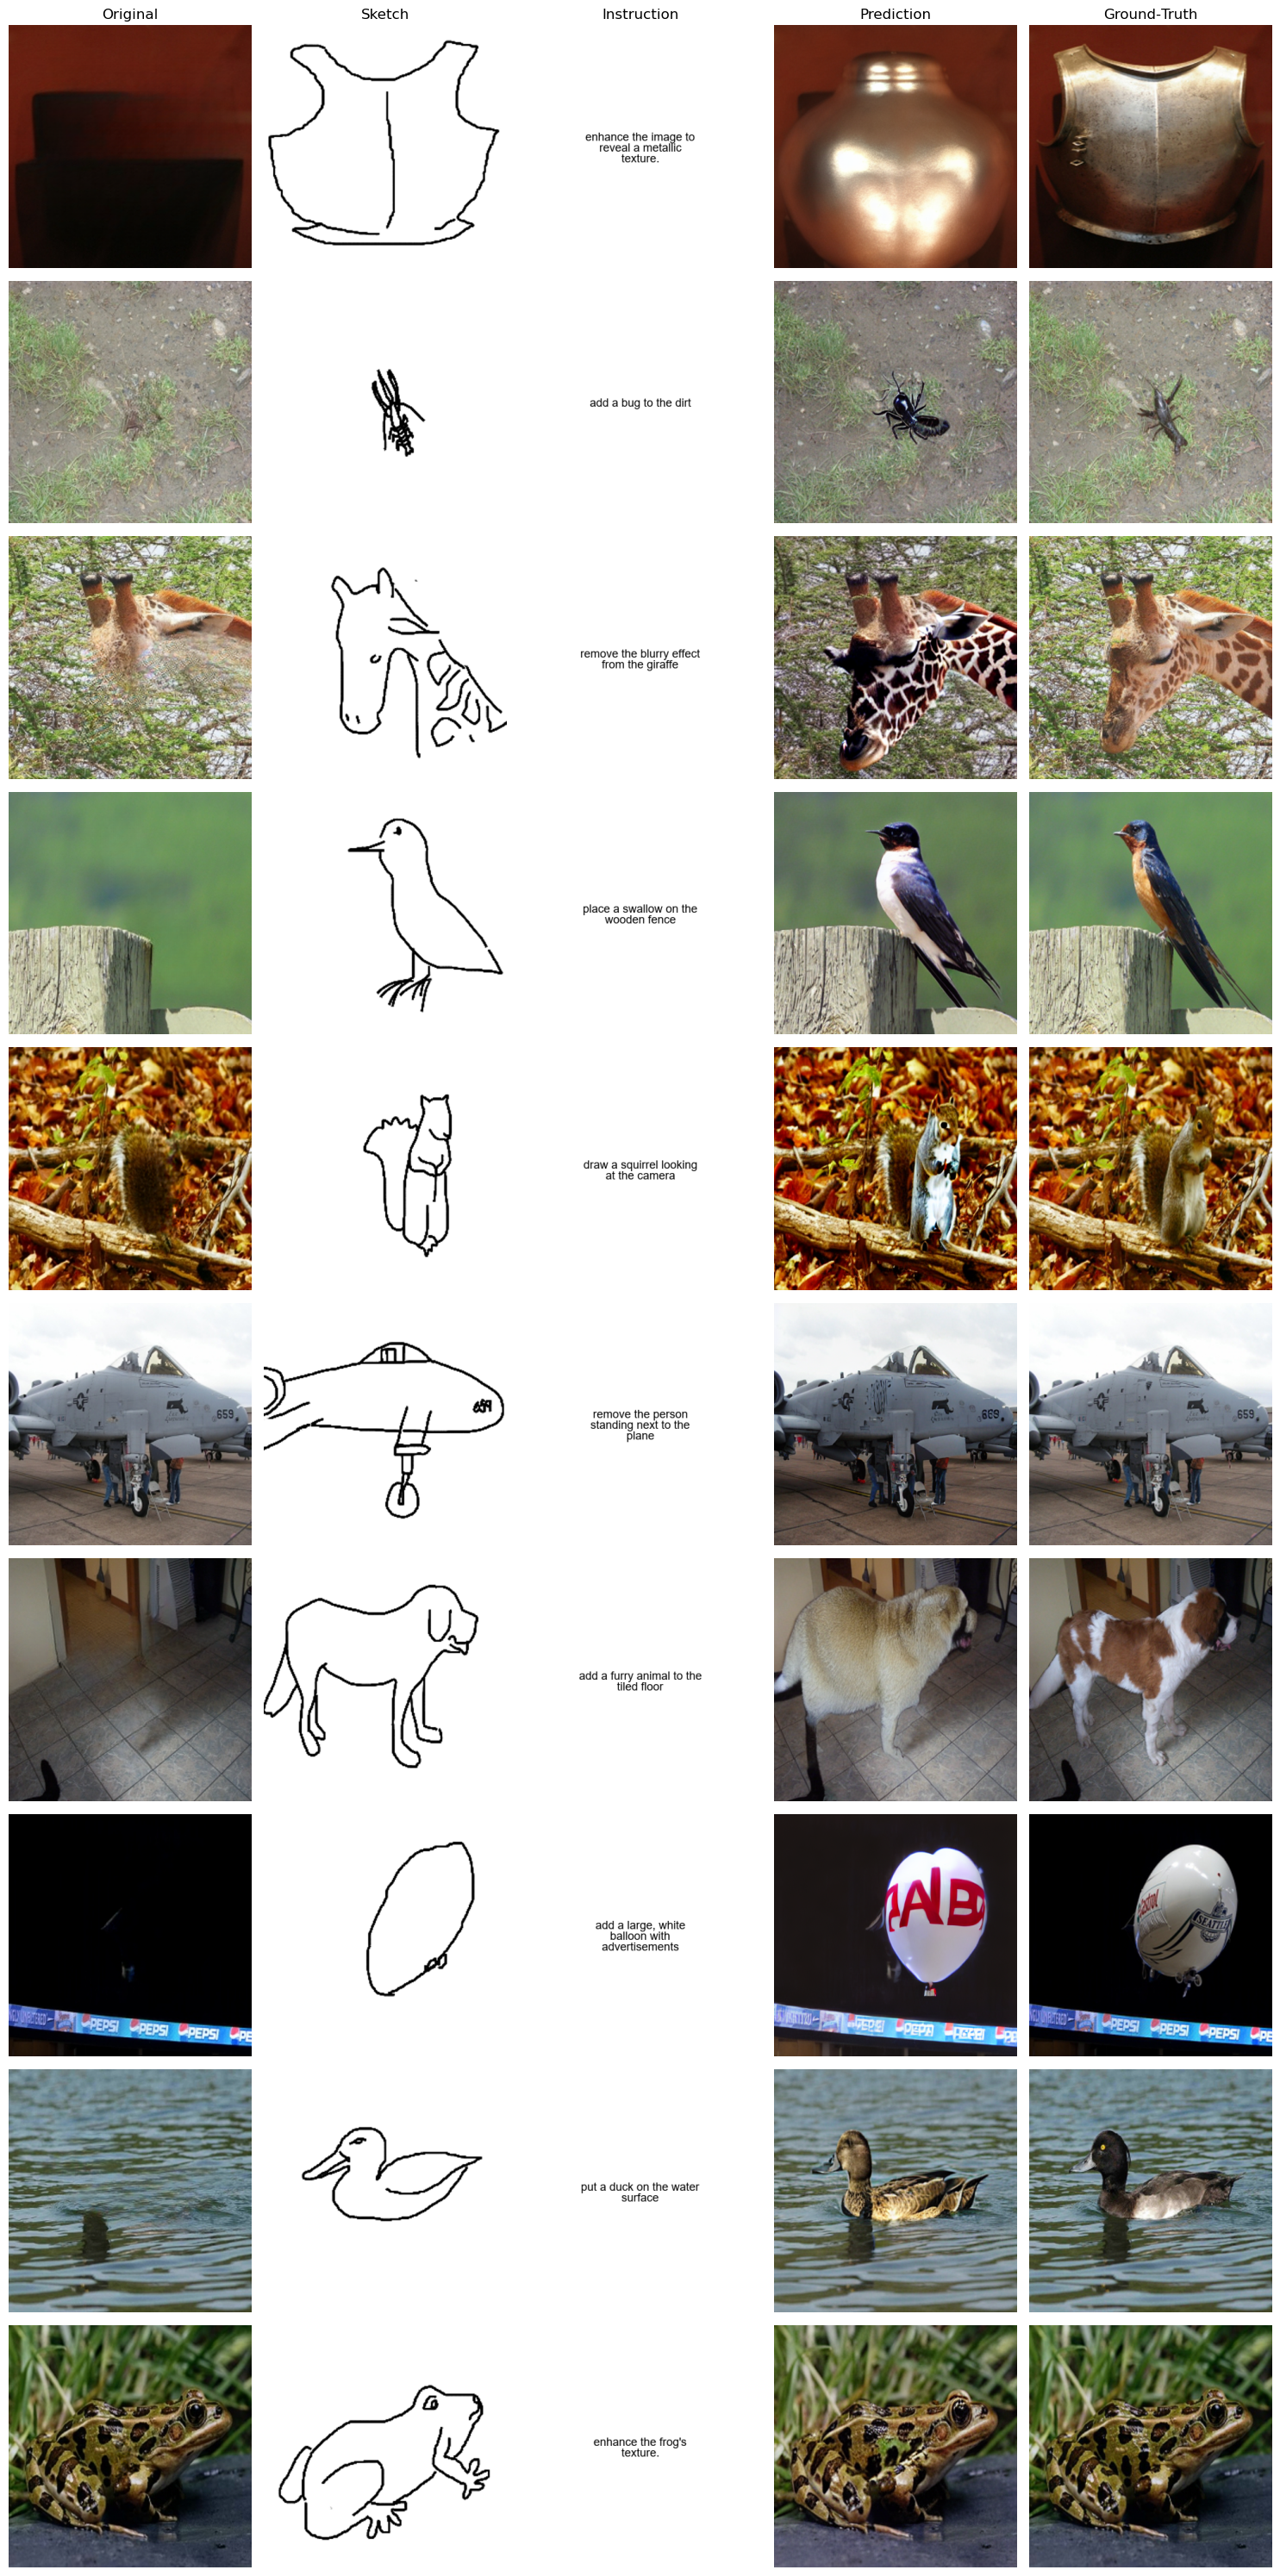

In [32]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import textwrap
import os

num_batches_to_show = 5

# Create prediction folder if it doesn't exist
prediction_folder = "prediction"
os.makedirs(prediction_folder, exist_ok=True)

all_rows = []
file_idx = 0
for b_idx, batch in enumerate(val_loader):
    # if b_idx >= num_batches_to_show:
    #     break

    B = batch["original_image"].size(0)
    preds = [
        generate_edit(
            batch["original_image"][i],
            batch["sketch_image"][i],
            batch["edit_text"][i],
        ).cpu()
        for i in range(B)
    ]

    for i in range(B):
        H, W = batch["original_image"][i].shape[1:]
        pred_np = to_numpy(preds[i])
        
        # Save predicted image
        pred_img = Image.fromarray((pred_np * 255).astype(np.uint8))
        pred_img.save(os.path.join(prediction_folder, f"{file_idx}.png"))
        file_idx += 1
        
        row = [
            to_numpy(batch["original_image"][i]),
            to_numpy(batch["sketch_image"][i]),
            np.asarray(text_panel(batch["edit_text"][i], size=W)),
            pred_np,
            to_numpy(batch["target_image"][i]),
        ]
        all_rows.append(row)

# n_rows = len(all_rows)
# fig, axes = plt.subplots(n_rows, 5, figsize=(15, 3 * n_rows))
# if n_rows == 1:
#     axes = axes[None, :]

# titles = ["Original", "Sketch", "Instruction", "Prediction", "Ground‑Truth"]
# for r, row in enumerate(all_rows):
#     for c, img_np in enumerate(row):
#         ax = axes[r, c]
#         ax.imshow(img_np)
#         if r == 0:
#             ax.set_title(titles[c], fontsize=12)
#         ax.axis("off")

# plt.tight_layout()
# plt.show()